In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from functools import partial
from pathlib import Path
import torchvision

import math
import matplotlib.pyplot as plt
import re


from scripts.dataloader import Dataset, Transforms, Resize, ToTorch, Sampler, collate, DataLoader
from scripts.custom_models import Lambda, flatten, MixedInputModel, TabularModel, CNNModel, CustomResnet
from scripts.optimizer_and_loss import Optimizer, MSE_Loss, get_example_dataloaders, get_example_model

# Step 0 - Imports from previous lessons

The main things that we need from the previous lessons are the dattaloaders, the model, the loss function and the optimizer.  We don't need the training function because we will be rewriting it to include callbacks

In [3]:
dl_train, dl_valid = get_example_dataloaders()
model = get_example_model(dl_train)
loss_function = MSE_Loss(reduce = True)
opt = Optimizer(model, 0.02)

# Step 1 - Introduction to the Callback System

A callback is a supporting function, or group of functions, that can be called at various preset points within the code.  This allows the user to customize the functionality of the code without modifying the core components directly.  For instance, after each epoch of training, we may wish to change the learning rate.  This could be achieved with a callback that gets triggered before (or after) every completed epoch of training.  Alternatively, we might also want a callback that can break the training cycle if the validation loss starts to rise (early stopping).  Callbacks may even provide core functionality, such as the ability to use assess custom metrics during validation (e.g. an accuracy score)

We can therefore create a list of desired features from our callbacks:
- The ability to be called at specific points in the training cycle
- The ability to mix and match different types of callbacks
- The ability to change core parameters related to training
- The ability to store parameters
- The ability to stop training
- A callback system that is easy to program

The easiest way to call callbacks at specific landmarks in the code is to assign each of these landmarks a name.  For instance, we can call the point right after we calculate the loss "after loss", or the point right after we end a single batch "after batch".  Each of our callbacks should have functions related to these points, but we also don't want to have to program each function for every callback.  This is especially true when you just want the callback to access a single point (e.g. decreasing the learning rate by 10% after every batch).  We can get around this issue by creating a callback class which accepts a string when called (e.g. 'after batch') and only performs the operation if it has that function  

In [4]:
#export
class Callback():

    _order = 0 #This allows you to control the order callbacks are called in
    def __init__(self): self.learn = None
    def set_learner(self,learn): self.learn = learn
    def __getattr__(self, attr): return getattr(self.learn, attr)  #Will look here if it can't find it in the current class
    
    def __call__(self, callback):
        f = getattr(self, callback, None)
        if f and f(): return True   #f() won't be called if f is None
        else: return False
        
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    
        
_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

That's all there is too it.  For instance, we can create a simple callback to test out the functionality

In [5]:
class TestCallback(Callback):
    def example_callback(self):
        print ("It works")
        
class TestCallback2(Callback):
    def begin_batch(self):
        print("Starting the batch!")
    
    
test_callback = TestCallback()
#test_callback.set_learner(None)

test_callback("example_callback")
test_callback("unimplemented_callback")

It works


False

We can see that when the callback has the function it is called, but when it doesn't it returns False.  We will later incorporate the callbacks into a larger "learn" class, but just ignore the `set_learner` and `__getattr__ ` for now.

We can create a callback manager class to handle all of our callbacks.  Its main purpose will be to go through each of the registered callbacks whenever they're by the the training cycles.  We will accept two forms of callbacks as inputs.  The first is the initalized callback instances (e.g. test_callback from above).  The other is the uninitialized class (e.g. TestCallback), which must be called by the callback mananger to be initialized

In [6]:
class CallbackMananger():
    def __init__(self, callbacks, callback_functions):
        self.callbacks = []
        self.add_callbacks(callbacks)
        self.add_callbacks([cbf() for cbf in callback_functions])
        
    def add_callbacks(self, cbs):
        for cb in cbs: 
            cb.set_learner(None)
            self.callbacks.append(cb)
            
    def __call__(self, callback_name):
        result = False
        for cb in sorted(self.callbacks, key = lambda x: x._order): result = cb(callback_name) and result
        return result
        

In [7]:
cbm = CallbackMananger(callbacks = [TestCallback()], 
                       callback_functions = [TestCallback2])

Let's create a simplified version of our training cycle.  Note, we'll be able to clean up aspects like move_data_to_GPU in just a bit

In [8]:
def move_data_to_GPU(xb, yb):
    xb = tuple(map(lambda x: x.cuda(), xb))
    yb = yb.cuda()
    return xb, yb

model.cuda()
training = True

xb, yb = next(iter(dl_train))
xb, yb = move_data_to_GPU(xb, yb)
def one_batch(xb, yb):
    cbm('begin_batch')
    preds = model(xb)
    cbm('after_pred')
    loss = loss_function(preds, yb)
    cbm('after_loss')
    if training:
        loss.backward()
        cbm('after_loss')
        opt.step()
        cbm('after_step')
        opt.zero_grad()
        cbm('after_batch')


In [9]:
one_batch(xb, yb)

Starting the batch!


The next feature we want to add in is the ability to cancel the batch early.  We can do this using exceptions.  Let's add a callback that stops the batch after the loss

In [10]:
class StopAfterLoss(Callback):
    def __init__(self):
        self.temp_variable = None #To show that callbacks can store variables or be initialized
        
    def after_loss(self):
        print('About to cancel the batch')
        raise CancelBatchException("Cancelling the training cycle")
        
    def after_cancel_batch(self):
        print('Cancelled the batch!')
        
        
class CancelBatchException(Exception): pass

In [11]:
def one_batch(xb, yb):
    try:
        cbm('begin_batch')
        preds = model(xb);                 cbm('after_pred')
        loss = loss_function(preds, yb);   cbm('after_loss')
        if training:
            loss.backward();               cbm('after_loss')
            opt.step();                    cbm('after_step')
            opt.zero_grad()
            
    except CancelBatchException:           cbm('after_cancel_batch')
        
    finally: cbm('after_batch')

In [12]:
cbm = CallbackMananger(callbacks = [TestCallback()], 
                       callback_functions = [TestCallback2, StopAfterLoss])

one_batch(xb, yb)

Starting the batch!
About to cancel the batch
Cancelled the batch!


# Step 2 - The Learner Class

This is all we need for the foundations of a callback system.  We've addressed all of the requirements except for the ability to change core parameters associated with training.  For that, we want a larger structure than the callback mananger.  One that completely controls the entire training process.  To that end, we will create a Learner class, which will do double duty as the callback manager.  We will also create a `DataBlock` class that will contain our dataloaders (rather than have multiple possibilities in terms of the training, validation, and test sets)

In [13]:
#export
class Datablock():
    def __init__(self, train_dl, valid_dl = None, test_dl = None):
        self.train_dl, self.valid_dl, self.test_dl = train_dl, valid_dl, test_dl
        


class PreLearner():
    def __init__(self, model, data, loss_func, opt, cbs, cbfs):
        self.model = model
        self.loss_func = loss_func
        self.opt = opt
        self.data = data
        
        self.callbacks = []
        self.add_callbacks(callbacks)
        self.add_callbacks([cbf() for cbf in callback_functions])
        
    def add_callbacks(self, cbs):
        for cb in cbs: 
            cb.set_learner(self)
            self.callbacks.append(cb)
            
    def one_batch(self, xb, yb):
        try:
            self.xb, self.yb = xb, yb;                          self('begin_batch')
            self.preds = self.model(self.xb);                   self('after_pred')
            self.loss = self.loss_func(self.preds, self.yb);    self('after_loss')
            if training:
                self.loss.backward();                           self('after_loss')
                self.opt.step();                                self('after_step')
                self.opt.zero_grad()

        except CancelBatchException:                            self('after_cancel_batch')

        finally:                                                self('after_batch')
            
            
    def __call__(self, callback_name):
        result = False
        for cb in sorted(self.callbacks, key = lambda x: x._order): result = cb(callback_name) and result
        return result
        

Let's test out the ability to access and write data to the learner using a new callback:

In [14]:
class PredictionDoubler(Callback):
    def after_pred(self):
        pred = self.preds #This will call the __getattr__ class method when it doesn't find self.pred
        self.learn.test_output = "If you see this, we've set a value to the learner"

In [15]:
data = Datablock(dl_train, dl_valid)
callbacks = [TestCallback()]
callback_functions = [TestCallback2, StopAfterLoss, PredictionDoubler]
learn = PreLearner(model = model, 
                data = data, 
                loss_func = loss_function, 
                opt = opt, cbs = callbacks, cbfs = callback_functions)

In [16]:
learn.one_batch(xb,yb)

print(learn.test_output)

Starting the batch!
About to cancel the batch
Cancelled the batch!
If you see this, we've set a value to the learner


We now have something that is working and fulfils all of the requirements.  There is more to the training cycle than the ability to perform one batch.  Similarly, we can start to push some of the features to the callbacks themselves (e.g. moving the data to the GPU).  The main things that we need to add to our final learner are:
- The ability to switch between training and validation mode
- The ability to iterate through an entire epoch
- The ability to iterate over multiple epochs
- The ability to check that any callbacks are in the defined list

In terms of callbacks, we want to add the following features:
- The ability to move the batch data to the GPU
- The ability to keep track of the loss over time
- The ability to add another validation metric
- The ability to stop the training after 3 batches and 2 epochs (so that we can test more easily)

In [17]:
#export
class Learner():
    def __init__(self, model, data, loss_func, opt, cbs, cbfs):
        self.model = model
        self.loss_func = loss_func
        self.opt = opt
        self.data = data
        
        self.callbacks = []
        self.add_callbacks([TrainEvalCallback()] + cbs)
        self.add_callbacks([cbf() for cbf in cbfs])
        
    def add_callbacks(self, cbs):
        for cb in cbs: 
            cb.set_learner(self)
            setattr(self, cb.name, cb)
            self.callbacks.append(cb)
          
    def fit(self, num_epochs):
        self.num_epochs = num_epochs
        try: 
            self.loss = torch.tensor(0.);                       self('begin_fit')
            for epoch in range(num_epochs):
                self.epoch = epoch
                if not self('begin_epoch'): #Will return False unless you want to skip the epoch
                    #train cycle
                    #self.in_train = True
                    #self.model.train()
                    self.dl = self.data.train_dl
                    self.all_batches()
                
                    #valid cycle
                    if not self('begin_validate'):  #Will return False unless you want to skip validation
                        #self.in_train = False
                        #self.model.eval()
                        self.dl = self.data.valid_dl
                        with torch.no_grad(): self.all_batches() # May have to move torch no grad up
                self('after_epoch')
            
        except CancelTrainException:                            self('after_cancel_train')
        finally:                                                self('after_fit')
        
    def all_batches(self):
        try:
            for i, (xb, yb) in enumerate(self.dl):
                self.one_batch(i, xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb, self.yb = xb, yb;                          self('begin_batch')
            self.preds = self.model(self.xb);                   self('after_pred')
            self.loss = self.loss_func(self.preds, self.yb);    self('after_loss')
            if self.in_train:
                self.loss.backward();                           self('after_loss')
                self.opt.step();                                self('after_step')
                self.opt.zero_grad()

        except CancelBatchException:                            self('after_cancel_batch')

        finally:                                                self('after_batch')
           
    ALL_CALLBACKS = {'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step',
        'after_cancel_batch', 'after_batch', 'after_cancel_epoch', 'begin_fit',
        'begin_epoch', 'begin_validate', 'after_epoch',
        'after_cancel_train', 'after_fit'}
        
    def __call__(self, callback_name):
        result = False
        assert callback_name in self.ALL_CALLBACKS
        for cb in sorted(self.callbacks, key = lambda x: x._order): result = cb(callback_name) and result
        return result
        

        
        
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.learn.n_epochs = 0
        self.learn.n_iter = 0
        
    def begin_epoch(self):
        self.learn.n_epochs = self.epoch
        self.model.train()
        self.learn.in_train = True
        
    def begin_validate(self):
        self.model.eval()
        self.learn.in_train = False
        
        
        
        
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass




In [18]:
#export
class MoveBatchGPUCallback(Callback):
    _order = 100 #We want this to be done last, potentially (some operations may be requied before or after it)
    def begin_batch(self):
        self.learn.yb = self.yb.cuda()
        self.learn.xb = tuple(map(lambda x: x.cuda(), xb))
    def begin_fit(self):
        self.model.cuda()
        
class EarlyStoppingCallback(Callback):
    def __init__(self, max_epochs, max_batches):
        self.max_epochs = max_epochs
        self.max_batches = max_batches
    def after_epoch(self):
        if self.epoch >= self.max_epochs: raise CancelTrainException()  
    def after_batch(self):
        if self.iter >= self.max_batches: raise CancelEpochException()
            
class OutputStepsCallback(Callback):
    def begin_batch(self): print(f"   Batch {self.iter}")
    def begin_epoch(self): print(F"Epoch {self.epoch}", "\nBeginning the Training")
    def begin_validate(self): print("Beginning the validation")
    
class SqueezePredsCallback(Callback):
    def after_pred(self):
        self.learn.preds = torch.squeeze(self.learn.preds, -1)

In [19]:
data = Datablock(dl_train, dl_valid)
callbacks = [OutputStepsCallback(), EarlyStoppingCallback(2, 3)]
callback_functions = [MoveBatchGPUCallback, SqueezePredsCallback]
learn = Learner(model = model, 
                data = data, 
                loss_func = loss_function, 
                opt = opt, cbs = callbacks, cbfs = callback_functions)

In [20]:
learn.fit(20)

Epoch 0 
Beginning the Training
   Batch 0
   Batch 1
   Batch 2
   Batch 3
Beginning the validation
   Batch 0
   Batch 1
   Batch 2
   Batch 3
Epoch 1 
Beginning the Training
   Batch 0
   Batch 1
   Batch 2
   Batch 3
Beginning the validation
   Batch 0
   Batch 1
   Batch 2
   Batch 3
Epoch 2 
Beginning the Training
   Batch 0
   Batch 1
   Batch 2
   Batch 3
Beginning the validation
   Batch 0
   Batch 1
   Batch 2
   Batch 3


We've shown some simple callbacks that handle basic actions, such as early stopping and outputting the current steps so that we can track progress during training.  The good thing about using callbacks to perform these tasks is that we can easily mix and match at runtime.  It also increases the flexibility of the system.  For instance, we need a vey specific unpacking and repacking process when moving the xb to the GPU, which is made simple by having this behaviour in its own callback.  There are other steps that could have been pushed to a callback as well, such as identifying the `model.eval()` and `model.train()` steps.  What you choose to push to callbacks and what you choose to incorporate into the code is up to you.

# Step 3 - More Sophisticated Callbacks

In addition to the simple callbacks we saw in the previous section, we can also look at more complex callbacks that interact with our learner in more complicated ways.  We will go over two of the most critical ones here:
- The ability to track loss and other specific metrics
- The ability to schedule specific parameters like the learning rate

## Stats and Metrics

The ability to track specific stats is a very useful tool when training your models.  Although the loss function is what the system uses for training the parameters, a metric such as accuracy may provide a more tangible representation of the performance of the model.  Alternatively, you may wish to extract very specific information that is not easily parsed from a single loss value.  For instance, you may want to separate the predictions based on each class and give a summary of each.  This is easily calculated using the preds and yb components stored in the learner.

To calculate stats, we will create a new 'AvgStats' class that will accumulate the metrics of interest across all the batches of an epoch and then append them to a amoving tally.  This class should have some key functionalities, including:
- The ability to reset the statistics easily
- The ability to average in batches of varying sizes (since the last batch sometimes has fewer elements - not a huge deal)
- The ability to accept a list of custom "metric functions"

To keep things simple, each metric will take two inputs: the predictions (output) and the yb (target).  This way, we can just call metric(self.preds, self.yb) to calculate the output of each metric


In [21]:
#export
class AvgStats():
    def __init__(self, metrics, in_train):
        self.metrics, self.in_train = metrics, in_train
        self.reset_stats()
        
    def reset_stats(self):
        self.tot_loss, self.count = 0., 0
        self.tot_metrics = [0.]*len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_metrics
    
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
        
    def accumulate(self, learn):
        batch_size = learn.preds.shape[0]
        self.tot_loss += learn.loss * batch_size
        self.count += batch_size
        for i, m in enumerate(self.metrics):
            self.tot_metrics[i] += m(learn.preds, learn.yb)*batch_size
        
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"
    
    
class AvgStatsCallback(Callback):
    def __init__(self, train_metrics, valid_metrics):
        self.train_stats, self.valid_stats = AvgStats(train_metrics, True), AvgStats(valid_metrics, False)
        
    def begin_fit(self):
        self.train_stats.reset_stats()
        self.valid_stats.reset_stats()
        
    def after_batch(self):
        current_stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): current_stats.accumulate(self.learn)
            
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        

In [22]:
data = Datablock(dl_train, dl_valid)
metrics = []


callbacks = [#OutputStepsCallback(), 
             EarlyStoppingCallback(2, 3), 
             AvgStatsCallback(metrics, metrics)]
callback_functions = [MoveBatchGPUCallback]
learn = Learner(model = model, 
                data = data, 
                loss_func = loss_function, 
                opt = opt, cbs = callbacks, cbfs = callback_functions)

learn.fit(20)

train: [nan]
valid: [nan]
train: [nan]
valid: [nan]


Now that we have the base for our statistics, lets add some random metrics to show some examples of what is possible:

In [23]:
def percent_close(output, target, tolerance = 0.1):
    within_tolerance = (abs(output-target))<tolerance
    return (within_tolerance*1.).mean().item()

def msle(output, target):
    logs = torch.log(output+1) - torch.log(target+1)
    return (logs**2).mean().item()

def mean_pred(output, target):
    return output.mean().item()

#random function


preds, yb = learn.preds, learn.yb
preds = yb+torch.rand(yb.shape).cuda() #simulate another preds function

for func in [percent_close, msle, mean_pred]:
    print(func(preds, yb))

0.0625
0.053211890161037445
1.6072728633880615


In [24]:
data = Datablock(dl_train, dl_valid)
metrics = [percent_close, msle, mean_pred]


callbacks = [#OutputStepsCallback(), 
             EarlyStoppingCallback(2, 3), 
             AvgStatsCallback(metrics, metrics)]
callback_functions = [MoveBatchGPUCallback]
learn = Learner(model = model, 
                data = data, 
                loss_func = loss_function, 
                opt = opt, cbs = callbacks, cbfs = callback_functions)

learn.fit(20)

train: [nan, 0.0, nan, nan]
valid: [nan, 0.0, nan, nan]
train: [nan, 0.0, nan, nan]
valid: [nan, 0.0, nan, nan]


## Parameter Scheduler

Another useful callback is the parameter scheduler, which allows us to modify specific parameters throughout the training process.  For instance, it is common to gradually decrease the learning rate as training progresses, allowing you to hone in on a local minimum.  Before we get started on the callback, we need a method of accepting an input (pos, or fraction of the training) and outputing our parameter

In [25]:
#export
def annealer(f):
    def _inner(start, stop):
        return partial(f, start, stop)
    return _inner

@annealer
def sched_lin(start, stop, pos): return start + (stop-start)*pos
@annealer
def sched_cos(start, stop, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (stop-start) / 2
@annealer
def sched_none(start, stop, pos): return start
@annealer
def sched_exp(start, stop, pos): return (start)*(stop/start)**pos

If we look at the cosine scheduler with a start of 2 and an end of 0.4,  we can see that our scheduler behaves as intended

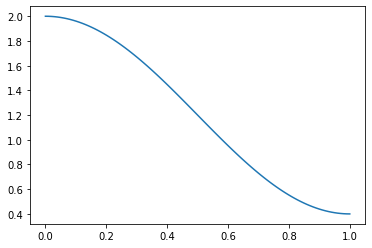

In [26]:
x = np.linspace(0, 1, 100)
f = sched_cos(2, 0.4)
y = [f(x) for x in x]

plt.plot(x, y)

We can also combine different schedulers to make new ones

In [27]:
#export
def sched_combiner(pcts, scheds):
    assert sum(pcts) == 1
    pcts = torch.tensor([0.] + pcts)
    pcts_cum = torch.cumsum(pcts, 0)
    def _inner(pos):
        if pos>=1: pos = 0.99999 #Error on the unlikely chance it hits 1.0 exactly
        idx = (pos>=pcts_cum).nonzero().max()
        new_pos = (pos - pcts_cum[idx])/(pcts_cum[idx+1] - pcts_cum[idx])
        return scheds[idx](new_pos)
    return _inner
        

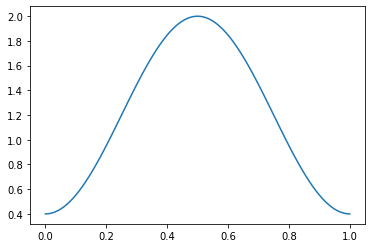

In [28]:
pcts = [0.5, 0.5]
scheds = [sched_cos(0.4, 2), sched_cos(2, 0.4)]
sched_new = sched_combiner(pcts, scheds)


x = np.linspace(0., 1., 100)
f = sched_new
y = [f(x) for x in x]
plt.plot(x, y)

The last step is to create a callback that will be able to change our parameter of choice according to the progress through the epoch

In [29]:
#export
class ParamSchedulerCallback(Callback):
    _order = 1
    def __init__(self, pname, scheduler):
        self.pname, self.scheduler = pname, scheduler
        
    def begin_fit(self):
        setattr(self.opt, self.pname, self.scheduler(0.))
        
    def begin_batch(self):
        pos = self.epoch/self.num_epochs
        if hasattr(self.learn, 'n_batches'): #if you've included a way to measure the dataset length
            pos += self.iter/self.learn.n_batches/self.num_epochs
        setattr(self.opt, self.pname, self.scheduler(pos))
           
class BatchNumberCalculator(Callback):
    def begin_fit(self):
        ds_len = self.learn.data.train_dl.sampler.n
        bs = self.learn.data.train_dl.sampler.bs
        self.learn.n_batches = ds_len//bs
        
        

In [30]:
data = Datablock(dl_train, dl_valid)
metrics = [percent_close, msle, mean_pred]


callbacks = [ParamSchedulerCallback('lr', sched_new), 
             EarlyStoppingCallback(2, 3), 
             AvgStatsCallback(metrics, metrics)]
callback_functions = [MoveBatchGPUCallback, BatchNumberCalculator]
learn = Learner(model = model, 
                data = data, 
                loss_func = loss_function, 
                opt = opt, cbs = callbacks, cbfs = callback_functions)

learn.fit(20)

train: [nan, 0.0, nan, nan]
valid: [nan, 0.0, nan, nan]
train: [nan, 0.0, nan, nan]
valid: [nan, 0.0, nan, nan]


In theory, we now have a method of changing parameters like the learning rate on the fly.  Let's create an easy way of testing this through a new callback: the Recorder

## Recorder

We can also give callbacks class methods that are useful beyond what they do in the actual training cycle.  For instance, we can build a recorder class to track the loss and learning rates over time

In [31]:
#export
class RecorderCallback(Callback):
    def begin_fit(self):
        self.losses = [[],[]]
        self.lrs = [[],[]]
        
    def after_loss(self):
        train_valid_selector = 0 if self.in_train else 1
        self.losses[train_valid_selector].append(self.loss)
        self.lrs[train_valid_selector].append(self.opt.lr)
    def plot_lrs(self, train = True):
        train_valid_selector = 0 if train else 1
        plt.plot(self.lrs[train_valid_selector])
        
    def plot_losses(self, train = True):
        plt.plot(self.losses[train_valid_selector])

To test the recorder callback, we'll make a few changes to our early stopper and call to .fit so that we train for 10 epochs, and do the first two batches of each

In [32]:
data = Datablock(dl_train, dl_valid)
metrics = [percent_close, msle, mean_pred]


callbacks = [ParamSchedulerCallback('lr', sched_new), 
             EarlyStoppingCallback(10, 1), 
             AvgStatsCallback(metrics, metrics)]
callback_functions = [MoveBatchGPUCallback, BatchNumberCalculator, RecorderCallback]
learn = Learner(model = model, 
                data = data, 
                loss_func = loss_function, 
                opt = opt, cbs = callbacks, cbfs = callback_functions)

learn.fit(10)

train: [nan, 0.0, nan, nan]
valid: [nan, 0.0, nan, nan]
train: [nan, 0.0, nan, nan]
valid: [nan, 0.0, nan, nan]
train: [nan, 0.0, nan, nan]
valid: [nan, 0.0, nan, nan]
train: [nan, 0.0, nan, nan]
valid: [nan, 0.0, nan, nan]
train: [nan, 0.0, nan, nan]
valid: [nan, 0.0, nan, nan]
train: [nan, 0.0, nan, nan]
valid: [nan, 0.0, nan, nan]
train: [nan, 0.0, nan, nan]
valid: [nan, 0.0, nan, nan]
train: [nan, 0.0, nan, nan]
valid: [nan, 0.0, nan, nan]
train: [nan, 0.0, nan, nan]
valid: [nan, 0.0, nan, nan]
train: [nan, 0.0, nan, nan]
valid: [nan, 0.0, nan, nan]


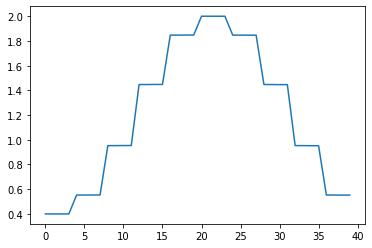

In [33]:
learn.recorder.plot_lrs()

As we can see, it's a bit blocky but has the general shape of our scheduler.  Had we trained will all the batches, the values in between would likely have smoothed out the curve

# Final Notes

In [34]:
!python scripts/notebook2script.py "Part 4 - Callbacks.ipynb" 'callbacks.py'

Converted Part 4 - Callbacks.ipynb to scripts\callbacks.py
